# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Trajectory-clustering-with-traj" data-toc-modified-id="Trajectory-clustering-with-traj-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Trajectory clustering with traj</a></div>

# Trajectory clustering with traj

Example of clustering time trajectories / time series with traj

traj vignette: https://cran.r-project.org/web/packages/traj/vignettes/trajVignette.pdf

In [126]:
library(tidyverse, quietly=T)
library(caret)
library(traj)
options(jupyter.plot_mimetypes = 'image/png')
mousephen = read.csv("datasets/mousephenotype/mousephenotypedata.csv") %>% 
    tbl_df %>%
    mutate(gene = paste0("gene", gene)
          #animal = paste0("animal", animal)
          )


mousephen %>% head

animal,gene,sex,zygosity,week,weight
116489494,gene143,1,0,4.000000,17.0
116489494,gene143,1,0,5.000000,20.2
116489494,gene143,1,0,6.000000,22.1
116489494,gene143,1,0,7.000000,25.2
116489494,gene143,1,0,7.428571,25.4
116489494,gene143,1,0,9.000000,26.4


Reading and plotting the data.


     animal              gene                sex            zygosity     
 Min.   : 37448824   Length:2849        Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 91998068   Class :character   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :116489502   Mode  :character   Median :1.0000   Median :1.0000  
 Mean   :110928012                      Mean   :0.5216   Mean   :0.6153  
 3rd Qu.:130783034                      3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :153843557                      Max.   :1.0000   Max.   :2.0000  
      week            weight     
 Min.   : 2.857   Min.   : 5.00  
 1st Qu.: 7.857   1st Qu.:19.37  
 Median :11.000   Median :22.54  
 Mean   :10.816   Mean   :22.72  
 3rd Qu.:14.000   3rd Qu.:26.20  
 Max.   :18.857   Max.   :37.80  

animal,gene,sex,zygosity,week,weight
261,17,2,3,109,1213


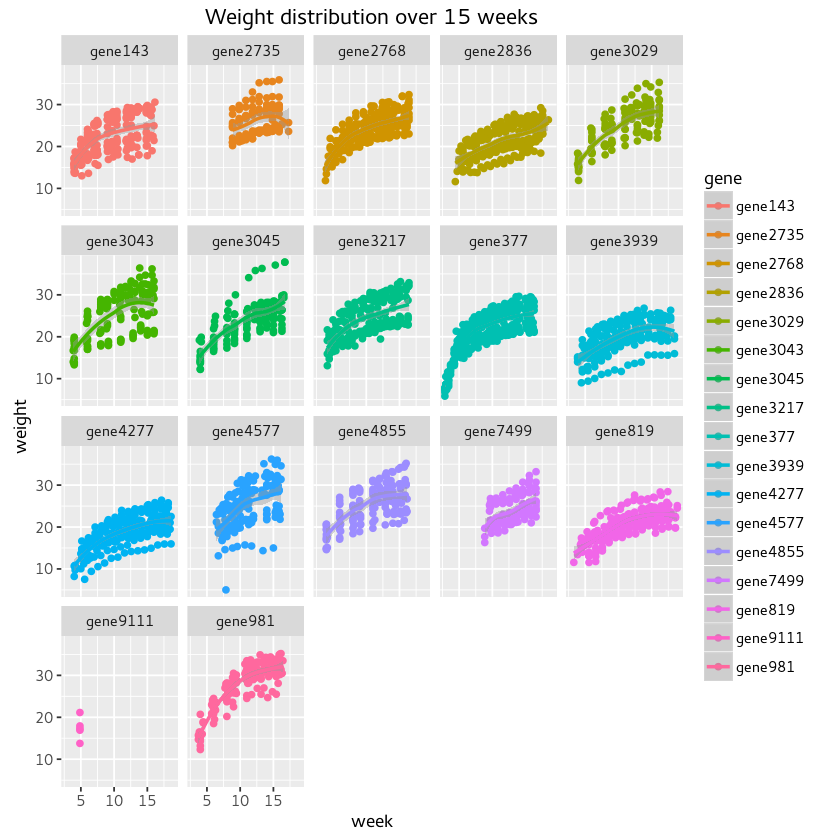

In [127]:
cat("Reading and plotting the data.\n")
mousephen %>% summary
mousephen %>% summarise_each(funs(n_distinct(.)))

#graphics::plot(mousephen$x,  mousephen$y)
p = mousephen %>% ggplot(aes(x=week, y=weight, color=gene)) + 
    geom_point() +
    facet_wrap(~gene) + 
    geom_smooth() +
    ggtitle("Weight distribution over 15 weeks") 
print(p)

In [128]:
cat("Preparing data for trajectory clustering. We need two matrixes, one with the time measurements, and one with the weights\n")

mousephen = mousephen %>% 
    group_by(animal) %>% 
    arrange(animal, week) %>% 
    mutate(measurementId = row_number()) %>% 
    mutate(days=week*7) %>%     
    filter(days>28) %>% # simplifying data
    ungroup 

mousephen.times = mousephen %>% 
    select(animal, measurementId, days) %>% 
    spread(measurementId, days) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
mousephen.values = mousephen %>% 
    select(animal, measurementId, weight) %>%  
    spread(measurementId, weight) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

cat("\nTime measurements, in days:\n")
mousephen.times 
mousephen.times %>% dim
cat("Weights:\n")
mousephen.values %>% head
mousephen.values %>% dim

Preparing data for trajectory clustering. We need two matrixes, one with the time measurements, and one with the weights

Time measurements, in days:


,animal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,37448824,30,36,43,50,57,65,73,76,85,90,97,104,113,NA,NA
2,37448827,30,36,43,50,57,65,73,76,85,90,97,104,113,NA,NA
3,37448830,NA,34,41,48,55,63,71,74,83,88,95,102,111,NA,NA
4,37448833,NA,34,41,48,55,63,71,74,83,88,95,102,111,NA,NA
5,37448836,61,69,72,81,86,93,100,109,NA,NA,NA,NA,NA,NA,NA
6,37626612,30,36,43,50,57,66,73,76,85,90,97,104,114,NA,NA
7,37658523,32,38,45,52,59,67,75,78,87,92,99,108,115,NA,NA
8,37658527,32,38,45,52,59,67,75,78,87,92,99,108,115,NA,NA
9,37658547,40,47,54,62,70,73,82,87,94,103,110,NA,NA,NA,NA
10,37658550,NA,33,40,47,54,62,70,73,82,87,94,103,110,NA,NA


[1] 260  16

Weights:


,animal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,37448824,15.94,18.60,20.20,20.63,21.88,22.68,22.39,22.16,23.18,23.39,23.29,24.88,24.59,NA,NA
2,37448827,15.61,17.36,19.39,21.26,22.46,22.31,22.63,22.59,24.11,24.31,24.58,25.95,25.13,NA,NA
3,37448830,NA,18.16,19.50,20.90,21.59,21.95,22.82,23.65,23.75,23.85,24.48,24.71,23.56,NA,NA
4,37448833,NA,15.14,18.26,19.14,19.72,19.84,20.82,21.03,22.74,22.11,22.19,22.54,23.15,NA,NA
5,37448836,22.29,22.86,23.05,24.13,23.53,24.79,25.13,24.79,NA,NA,NA,NA,NA,NA,NA
6,37626612,17.65,19.54,21.44,22.76,24.61,25.39,26.46,26.43,26.81,27.36,27.78,28.67,30.21,NA,NA


[1] 260  16

In [129]:
cat('Trajectory Clustering step 1 - calculating measures\n')
s1 = step1measures(mousephen.values, mousephen.times, ID=TRUE)
head(s1$measurments)  %>% print.data.frame


Trajectory Clustering step 1 - calculating measures
[1] "Correlation of m11 and m15 : 1"
        ID    m1       m2       m3        m4    m5         m6        m7
1 37448824  8.94 21.83154 2.477855 11.349886  8.65 0.10297619 0.5426600
2 37448827 10.34 22.13000 3.060479 13.829549  9.52 0.11333333 0.6098655
3 37448830  6.55 22.41000 2.048658  9.141714  5.40 0.06923077 0.2973568
4 37448833  8.01 20.55667 2.308787 11.231329  8.01 0.10269231 0.5290621
5 37448836  2.84 23.82125 1.044269  4.383772  2.50 0.05102041 0.1121579
6 37626612 12.56 25.00846 3.687729 14.745926 12.56 0.14776471 0.7116147
         m8         m9       m10  m11       m12        m13       m14  m15
1 0.3962158 0.08557814 0.8426032 2.66 0.9357297 0.14832213 0.8725000 2.66
2 0.4301853 0.10755985 0.8725103 2.03 0.9374466 0.13194977 0.9616667 2.03
3 0.2409639 0.07591595 0.8342582 1.40 0.7034551 0.11014853 0.7000000 1.40
4 0.3896546 0.08670815 0.8568908 3.12 0.9926411 0.14123729 0.8427273 3.12
5 0.1049483 0.05940666 0.8658768 1.26

In [131]:

cat('Trajectory Clustering step 2 - calculating factors\n')
s2= step2factors(s1)
s2

Trajectory Clustering step 2 - calculating factors
[1] "m15 is removed because it is perfectly correlated with m11"
[1] "Computing reduced correlation e-values..."


$factors
           ID       m2         m8       m10        m22
1    37448824 21.83154 0.39621578 0.8426032 0.08611395
2    37448827 22.13000 0.43018527 0.8725103 0.09896069
3    37448830 22.41000 0.24096386 0.8342582 0.06157965
4    37448833 20.55667 0.38965461 0.8568908 0.11383168
5    37448836 23.82125 0.10494831 0.8658768 0.07808154
6    37626612 25.00846 0.50223001 0.9318325 0.04398511
7    37658523 28.32462 0.36929010 0.9170888 0.08120146
8    37658527 27.06154 0.49405912 0.8140641 0.23612848
9    37658547 21.33364 0.18609111 0.8714787 0.10031108
10   37658550 25.67917 0.43381470 0.8395269 0.09423982
11   37748062 22.83000 0.41480508 0.8552587 0.10162067
12   37748066 20.48692 0.35241993 0.8605738 0.09030151
13   37884909 24.57077 0.32111327 0.9595054 0.02971010
14   37884913 25.41615 0.38518810 0.9407374 0.06728005
15   37884917 25.01500 0.17549470 0.9522887 0.06116330
16   37884948 27.54100 0.21168440 0.9446992 0.04502378
17   57128267 20.90538 0.38841668 0.7965381 0.11145454
1

In [134]:
cat('Calculating clusters\n')
s3 = step3clusters(s2, nclusters = 4)
cat('ok\n')

Calculating clusters


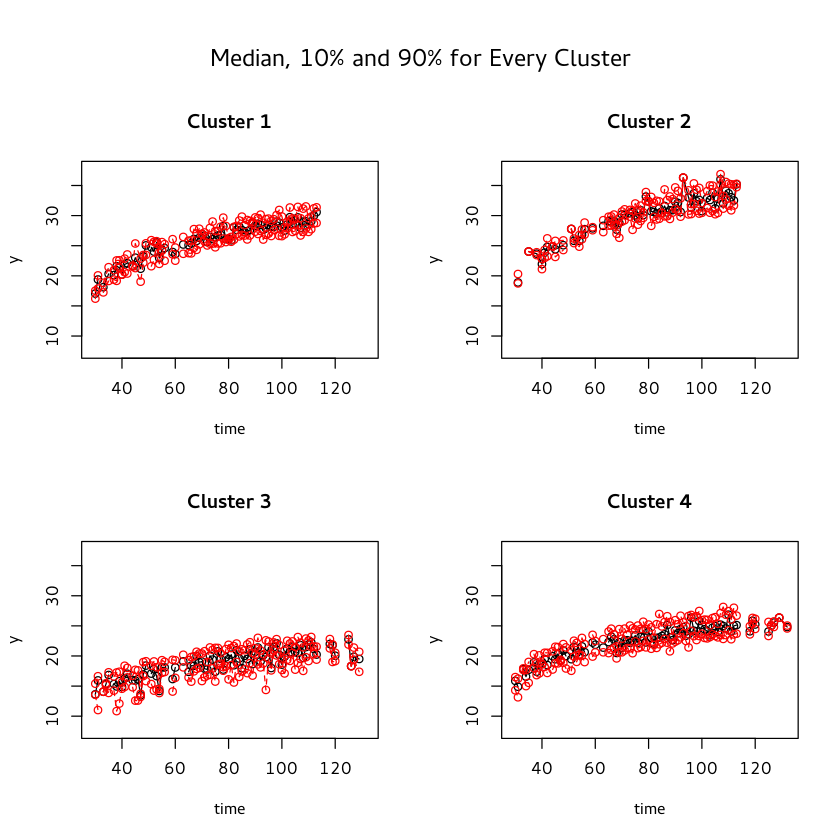

In [135]:
plotMedTraj(s3)

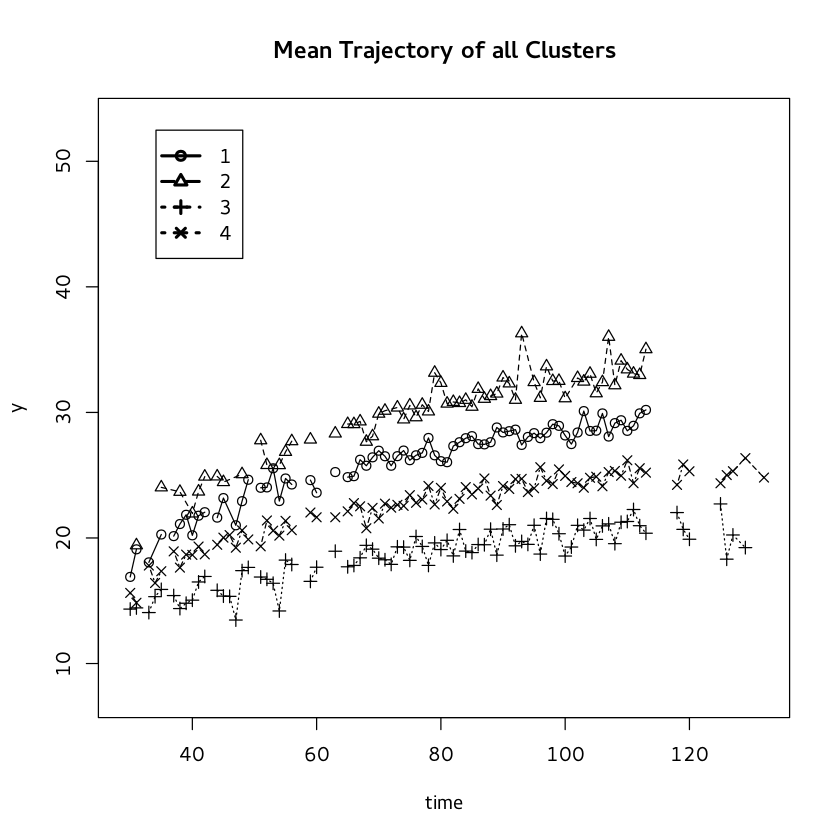

In [136]:
plotCombTraj(s3)

automatically calculating optimal number of cluster

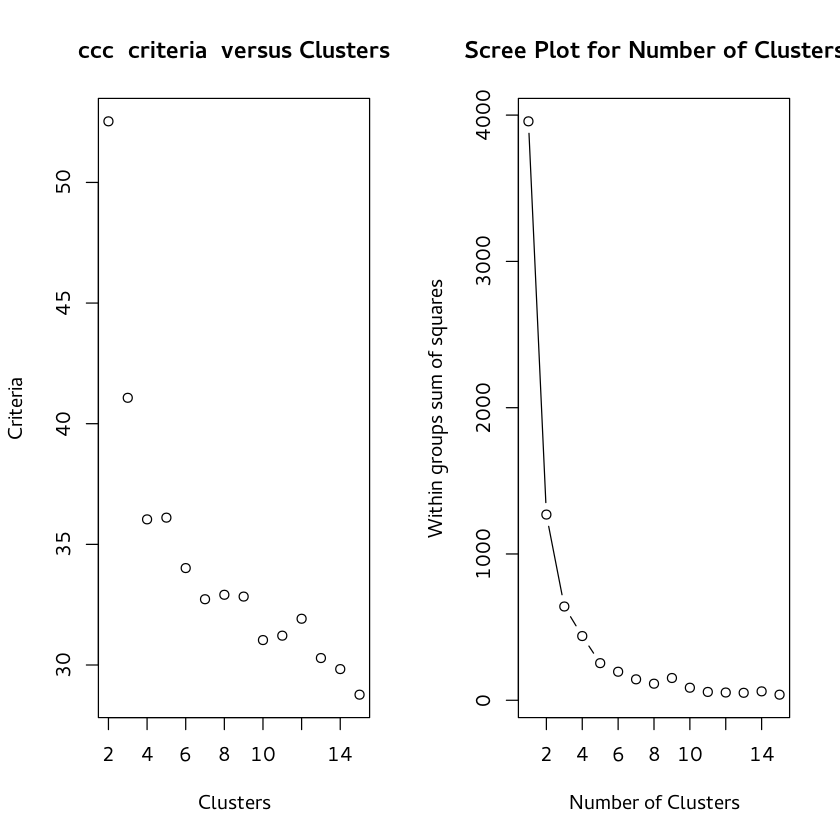

In [139]:
cat('automatically calculating optimal number of cluster')
s3.auto = step3clusters(s2)


  1   2 
 95 157 

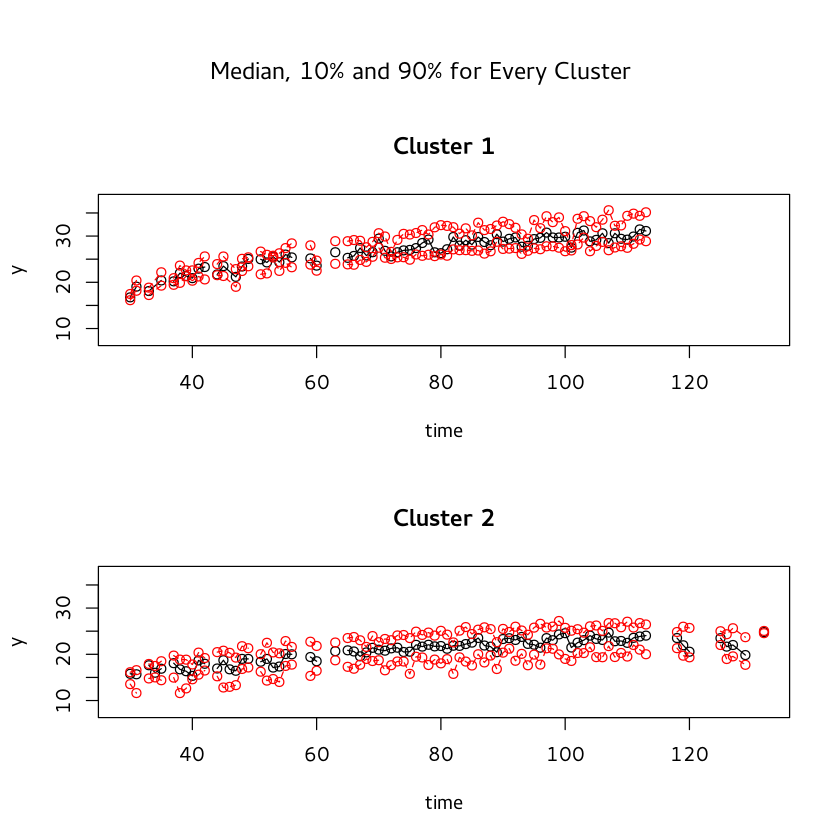

In [138]:
s3.auto$clust.distr
plotMedTraj(s3.auto)

Characterization of clusters

The two high growth classes have both an higher percentage of males. A regression may improve the prediction

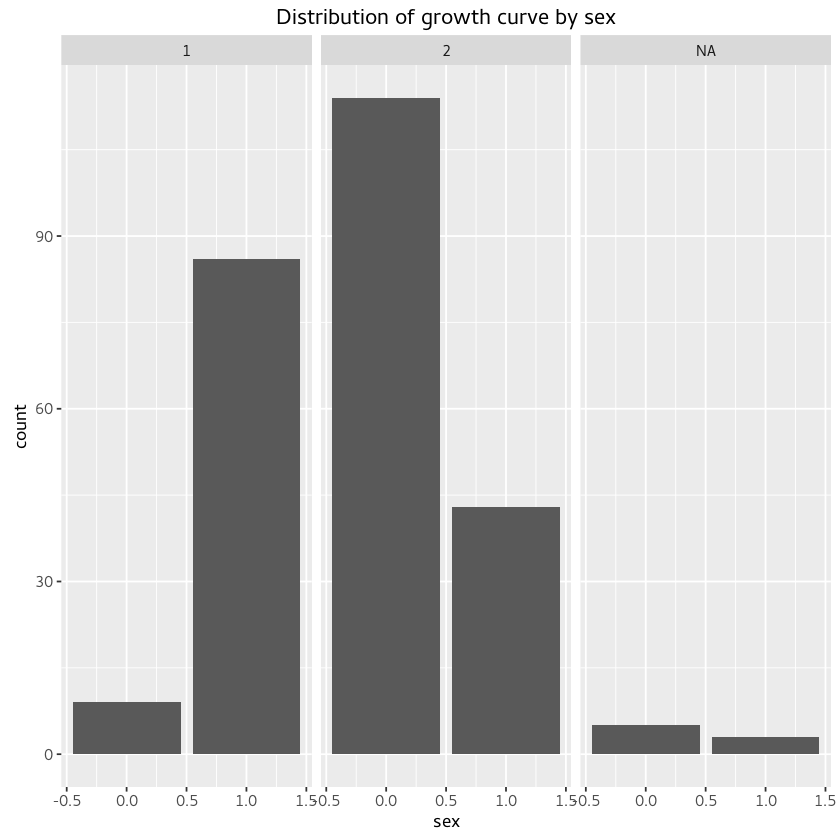

In [156]:
cat('Characterization of clusters')
#head(s3.auto$clusters)

mousephen.cl = mousephen %>% left_join(s3.auto$clusters %>% rename(animal=ID), by='animal')
#mousephen.cl %>% head

mousephen.cl %>% select(animal, sex, zygosity, cluster) %>%
    distinct %>%
    ggplot(aes(x=sex, fill=sex)) +
        facet_wrap(~cluster) +
        geom_bar() + 
        ggtitle("Distribution of growth curve by sex")
cat('The high growth class has an higher percentage of males. A regression may improve the prediction')

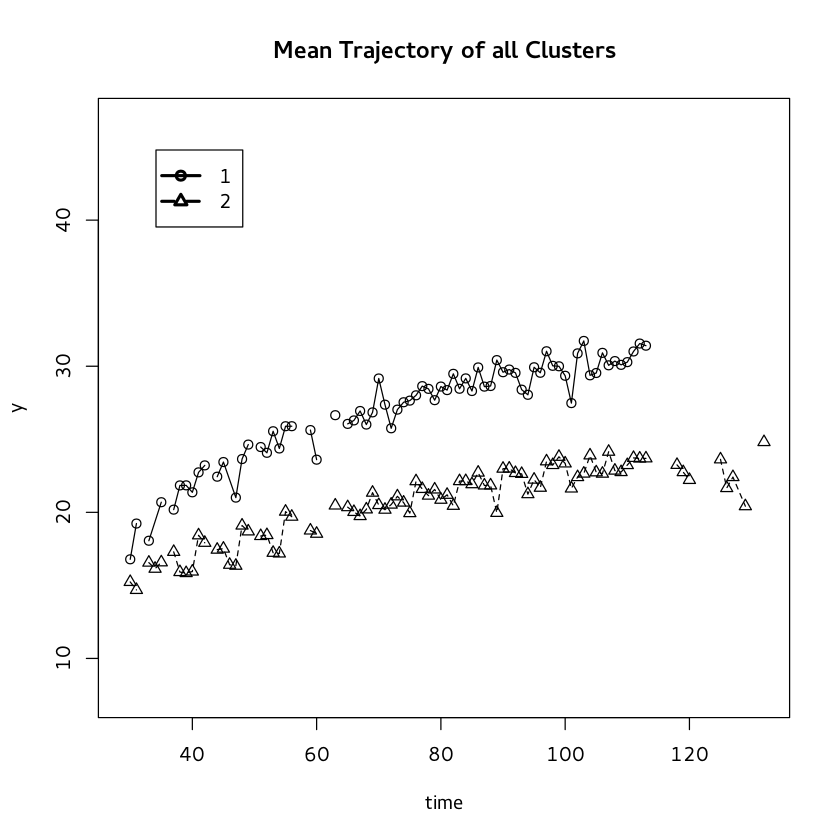

In [153]:
plotCombTraj(s3.auto)